# Understanding the problem

The task consists on continuing the work done before during previous module, with the addition of playing with non-linear models to improve the performance. Moreover, we're again asked to build a MVP within a API developed by our engineering team, so it must have a fit code and a inference code which later on we will define separatedly.

We will take all the decision and filters as granted from previous module, despite not being the best nor most accurate, such as:
- Baseline might be a linear model or global_popularity
- Feature selection might be more extensive
- Splittig sets using cumulative data instead of hard coded %'s. Even apply cross-validation addressing data leakages (ordered_before, global_popularity also if we are very nitpicky)

So we will copy all previous code and start from there applyin non-linear models, hence our baseline in this module would be the best model choosen in previous one (ridge regularisation with C=1e-5)

## Import libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import timedelta, datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import pickle
import os
import json
from typing import List, Dict, Optional
from catboost import Pool
from catboost import CatBoostClassifier
import traceback


# Functions used in previous MVP

In [14]:
def assess_NA(data: pd.DataFrame):
    """
    Returns a pd.DataFrame denoting the total number of NA
    values and the percentage of NA values in each column.
    """
    # pd.Datadenoting features and the sum of their null values
    nulls = data.isnull().sum().reset_index().rename(columns={0: "count"})
    nulls["percent"] = nulls["count"] * 100 / len(data)

    return nulls


def read_data(file_path: str) -> pd.DataFrame:
    """
    Read and validate data from a CSV file.
    Parameters: file_path (str)
    Returns: pd.DataFrame
    """
    try:
        data = pd.read_csv(file_path, index_col=False)

        if data is not None and not data.empty:
            logging.info("Data loaded successfully.")

            # Info about its shape and nulls
            rows, cols = data.shape
            logging.info(f"Data shape: {rows} rows x {cols} columns")

            null_assessment = assess_NA(data)
            logging.info(
                "Assessment of NA values:\n" + null_assessment.to_string(index=False)
            )

            # Show data sample
            print(data.head(5))

            return data
        else:
            logging.error("Error: The loaded data is empty or None")
            return

    except FileNotFoundError as e:
        logging.error(f"Error: The CSV file is empty. Details: {e}")
    except pd.errors.EmptyDataError as e:
        logging.error(
            f"Error: An unexpected error occurred while loading the data. Details {e}"
        )


def preprocess_data(
    data: pd.DataFrame, remove_if_all_na: bool = False, num_items: int = 5
) -> pd.DataFrame:
    """
    Preprocess data by removing rows with
    filter orders with at least 5 items

    Parameters:
    - data (pd.DataFrame)
    - remove_all_na_rows (bool): If True, remove rows where at least
    1 value is missing. If False, remove rows where all values are missing.

    Returns:
    - pd.DataFrame. The preprocessed dataset
    """
    try:
        initial_length = len(data)
        if remove_if_all_na:  # remove if everything is NA
            data = data.dropna(how="all")
        else:
            data = data.dropna()
        dropped_length = len(data)

        # Filter orders with >= 5 items
        num_items_ordered = data.groupby("order_id")["outcome"].transform("sum")
        processed_data = data[num_items_ordered >= num_items]

        logging.info(f"Length initial data: {len(data)}")
        logging.info(f"Rows dropped with NA's: {initial_length - dropped_length}")
        logging.info(f"Length filtered data: {len(processed_data)}\n")

        return processed_data

    except FileNotFoundError as e:
        logging.error(f"Error: File not found. Details {e}")
        return


def split_sets(df: pd.DataFrame, label: str) -> (pd.DataFrame, pd.Series):
    """
    Return a df with X set (features) and a series y set (outcome)

    Parameters:
    - df: pd.DataFrame

    Returns:
    - X: pd.DataFrame (features only)
    - y: pd.Series (label to predict)
    """
    X = df.drop(columns=label)
    y = df[label]

    return X, y


def temporal_data_split(
    data: pd.DataFrame,
    validation_days: int = 10,
    test_days: int = 10,
    label: str = "outcome",
    cols: List[str] = None,
):
    """
    Perform the temporal data splitting into train, validation, and test set.

    Parameters:
    - data : pd.DataFrame
    - validation_days (int): Number of days for the validation set (default: 10).
    - test_days (int): Number of days for the test set (default: 10).
    - label (str): Name of the outcome variable (default: 'outcome').

    Returns:
    - pd.DataFrame: Training set features.
    - pd.Series: Training set outcome.
    - pd.DataFrame: Validation set features.
    - pd.Series: Validation set outcome.
    - pd.DataFrame: Test set features.
    - pd.Series: Test set outcome.
    """
    try:
        # Check order_date is a datetime and then we group the orders
        try:
            data["order_date"] = pd.to_datetime(data["order_date"]).dt.date
        except KeyError as ke:
            logging.error(f"Key Error: {str(ke)}")
            return
        daily_orders = data.groupby("order_date").order_id.nunique()

        start_date = daily_orders.index.min()
        end_date = daily_orders.index.max()
        logging.info(f"Date from: {start_date}")
        logging.info(f"Date to: {end_date}")

        # Based on the number of days, we get the train days
        num_days = len(daily_orders)
        train_days = num_days - test_days - validation_days

        # Train
        train_start = daily_orders.index.min()
        train_end = train_start + timedelta(days=train_days)

        # Validation (no need to define test)
        validation_end = train_end + timedelta(days=validation_days)

        if cols is None:
            # Use all columns if cols is not specified
            cols = data.columns.tolist()

        train = data[data.order_date <= train_end][cols]
        val = data[(data.order_date > train_end) & (data.order_date <= validation_end)][
            cols
        ]
        test = data[data.order_date > validation_end][cols]

        logging.info(f"Train set ratio: {len(train) / len(data):.2%}")
        logging.info(f"Validation set ratio: {len(val) / len(data):.2%}")
        logging.info(f"Test set ratio: {len(test) / len(data):.2%}")

        X_train, y_train = split_sets(train, label)
        X_val, y_val = split_sets(val, label)
        X_test, y_test = split_sets(test, label)

        return X_train, y_train, X_val, y_val, X_test, y_test

    # not the best practice to catch all exceptio
    except KeyError as ke:
        logging.error(f"Key Error: {str(ke)}")
        return


def generate_evaluation_curves(
    model_name: str, C: float, y_pred, y_test, save_curves_path: str = None
):
    """
    Generate ROC and Precision-Recall curves for a binary classification model
    and save them in a single figure.

    Parameters:
    - model_name (str): Name of the model for labeling the curves.
    - y_pred (array-like): Predicted probabilities or scores.
    - y_test (array-like): True labels.
    - save_curves_path (str, optional): Directory to save the generated figure.
    If None, the figure will not be saved.

    Returns:
    - None
    """

    # Create a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f}) - {model_name} (C = {C:.2e})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(
        recall, precision, label=f"PR (AUC = {pr_auc:.2f}) - {model_name} (C = {C:.2e})"
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

    plt.tight_layout()

    if save_curves_path:
        # Define the filename with a timestamp
        figure_filename = f"Evaluation_Curves_{model_name}_C={C}_{timestamp}.png"
        figure_path = os.path.join(save_curves_path, figure_filename)

        plt.savefig(figure_path)

    plt.show()


def train_evaluate_model(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    save_model_path: str = None,
    save_curves_path: str = None,
):
    """
    Train, evaluate, and save a logistic regression model with hyperparameter
    tuning for regularisation. Additionally, plot the curves for ROC and PR.

    Parameters:
    - X_train (pd.DataFrame): Training set features.
    - y_train (pd.Series): Training set outcome.
    - X_val (pd.DataFrame): Validation set features.
    - y_val (pd.Series): Validation set outcome.
    - save_model_path (str, optional): Path to save the trained model.
    - save_curves_path (str, optional): Directory to save the generated figure.
    Returns:
    - None
    """
    # Define parameter grid for C values
    # We know in advance that strong params works better
    param_grid = {"lr__C": np.logspace(-8, -2, num=9)}

    # Create the pipeline
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(penalty="l2", solver="liblinear")),
        ]
    )
    try:
        # Search for the best C hyperparameter
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Get the best model and best parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Return probabilities for plotting the curves
        y_pred = best_model.predict_proba(X_val)[:, 1]

        # Print and save the evaluation curves (ROC and PR)
        generate_evaluation_curves(
            "LogisticRegression", best_params["lr__C"], y_pred, y_val, save_curves_path
        )

        # Save the best model
        if save_model_path:
            lr_C = best_params["lr__C"]
            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            model_filename = f"LogisticRegression_{lr_C}_{timestamp}.joblib"
            model_path = os.path.join(save_model_path, model_filename)
            joblib.dump(best_model, model_path)

            logging.info(f"Model {model_filename} saved  successfully!")
        else:
            logging.info("Model run but not saved")


    except ValueError as e:
        logging.error(f"ValueError: {str(e)}")

    except pickle.PickleError as e:
        logging.error(f"Error during model save: {str(e)}")

In [15]:
file_path = '/home/dan1dr/data/feature_frame.csv'
pd.set_option('display.max_columns', None)

logging.basicConfig(
    level=logging.INFO,  # Set logging level (others: DEBUG, WARNING, ERROR, etc.)
    format="%(levelname)s - %(message)s",  # Define the log message format
)

# We will remeber the classification we did in previous notebook:

predicted = ['outcome']
information = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
numerical = ['user_order_seq', 'normalised_price', 'discount_pct', 'global_popularity',
            'count_adults', 'count_children', 'count_babies', 'count_pets', 
            'people_ex_baby', 'days_since_purchase_variant_id', 
            'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
            'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
                'std_days_to_buy_product_type']

categorical = ['product_type', 'vendor']
binary = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']

cols = numerical + binary + predicted

In [16]:
data_loaded = read_data(file_path)
data_processed = preprocess_data(data_loaded)
X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed, cols = cols)
#train_evaluate_model(X_train, y_train, X_val, y_val)

INFO - Data loaded successfully.
INFO - Data shape: 2880549 rows x 27 columns
INFO - Assessment of NA values:
                           index  count  percent
                      variant_id      0      0.0
                    product_type      0      0.0
                        order_id      0      0.0
                         user_id      0      0.0
                      created_at      0      0.0
                      order_date      0      0.0
                  user_order_seq      0      0.0
                         outcome      0      0.0
                  ordered_before      0      0.0
                abandoned_before      0      0.0
                  active_snoozed      0      0.0
                  set_as_regular      0      0.0
                normalised_price      0      0.0
                    discount_pct      0      0.0
                          vendor      0      0.0
               global_popularity      0      0.0
                    count_adults      0      0.0
        

       variant_id     product_type       order_id        user_id  \
0  33826472919172  ricepastapulses  2807985930372  3482464092292   
1  33826472919172  ricepastapulses  2808027644036  3466586718340   
2  33826472919172  ricepastapulses  2808099078276  3481384026244   
3  33826472919172  ricepastapulses  2808393957508  3291363377284   
4  33826472919172  ricepastapulses  2808429314180  3537167515780   

            created_at           order_date  user_order_seq  outcome  \
0  2020-10-05 16:46:19  2020-10-05 00:00:00               3      0.0   
1  2020-10-05 17:59:51  2020-10-05 00:00:00               2      0.0   
2  2020-10-05 20:08:53  2020-10-05 00:00:00               4      0.0   
3  2020-10-06 08:57:59  2020-10-06 00:00:00               2      0.0   
4  2020-10-06 10:37:05  2020-10-06 00:00:00               3      0.0   

   ordered_before  abandoned_before  active_snoozed  set_as_regular  \
0             0.0               0.0             0.0             0.0   
1             0.

INFO - Length initial data: 2880549
INFO - Rows dropped with NA's: 0
INFO - Length filtered data: 2163953

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


# Non-linear models

We will apply different models and compare against previous results, in the following order:
- Decision Trees
- Random Forests
- Gradient Bosting Trees

In that sense, let's modify the generate_evaluation_curves to plot multiple funcs at the same time, in order to compare visually the performance of each model vs. baseline.

In [57]:
X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed, cols = cols)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


## Decision Tree

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from datetime import datetime
import os

def generate_evaluation_curves_multi(
    model_names: list, y_preds: list, y_test, save_curves_path: str = None
):
    """
    Generate ROC and Precision-Recall curves for multiple binary classification models
    and display them in a single figure.
    """

    # Create a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    plt.figure(figsize=(10, 5))

    # Plot for each model
    for model_name, y_pred in zip(model_names, y_preds):

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f}) - {model_name}")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        pr_auc = auc(recall, precision)

        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.2f}) - {model_name}")

    # ROC Curve settings
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right", prop={'size': 6})
    
    # Precision-Recall Curve settings
    plt.subplot(1, 2, 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right", prop={'size':6})

    plt.tight_layout()

    if save_curves_path:
        # Define the filename with a timestamp
        figure_filename = f"Evaluation_Curves_Multiple_Models_{timestamp}.png"
        figure_path = os.path.join(save_curves_path, figure_filename)

        plt.savefig(figure_path)

    plt.show()

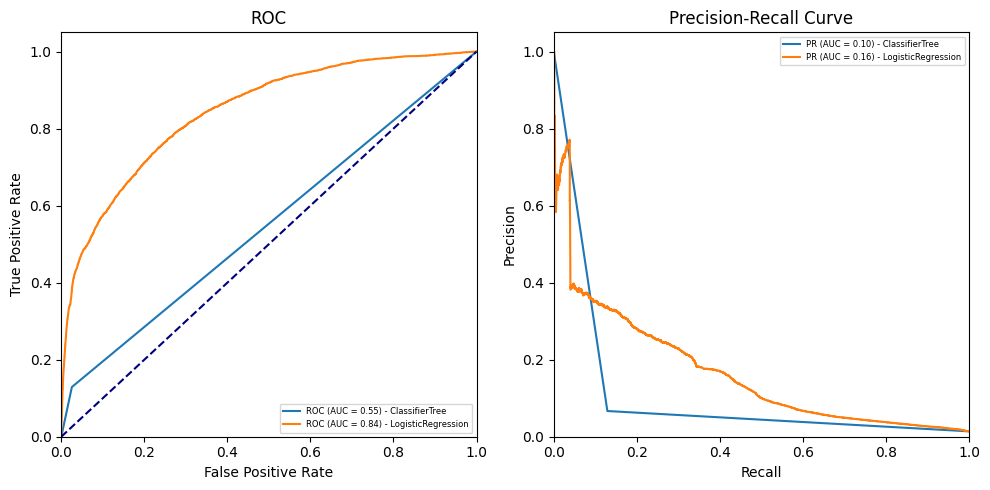

In [110]:
from sklearn.tree import DecisionTreeClassifier

# Train regression tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_val)

# Train logistic regression
lr = LogisticRegression(penalty="l2", C=1e-5, solver="liblinear")
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_val)[:, 1]

generate_evaluation_curves_multi(
    model_names=["ClassifierTree", "LogisticRegression"],
    y_preds=[y_pred_tree, y_pred_lr],
    y_test= y_val
)


Obviously, a single decision tree will hardly beat it. So we will try using random forests with different params of n_trees. As as curiosity, if we take a look at the plot for LR with same parameters as trained before, the AUC for PR is 0.16 vs 0.17 before (C, solver and  regularisation remains equal). I think this might happen as model regularisation can still have some randomness in model weights, hence getting different results. For addressing that we could have made use of random_seed.

## Random Forests

In [35]:
# Train Logistic Regression
lr = LogisticRegression(penalty="l2", C=1e-5, solver="liblinear")
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_val)[:, 1]

# Train RandomForestClassifier for various n_trees
trained_models = []
y_preds_rf = []

n_trees_values = [5, 20, 50, 100, 250]
for n_trees in n_trees_values:
    rf = RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_train, y_train)
    y_preds_rf.append(rf.predict_proba(X_val)[:, 1])

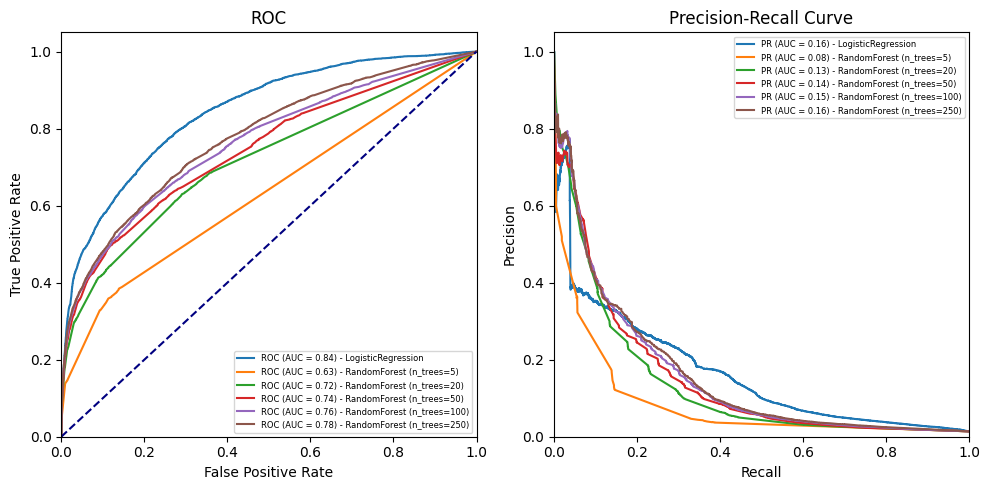

In [38]:
model_names = ["LogisticRegression"] + [f"RandomForest (n_trees={n})" for n in n_trees_values]
y_preds = [y_pred_lr] + y_preds_rf

generate_evaluation_curves_multi(model_names, y_preds, y_val)

For ROC we see no improvement, whereas higher number of trees works better than just a few. This model didn't improve our baseline defined by the linear model in blue.

In Precision-Recall, we obtain similar AUC for 200 trees, with better results for RandomForest between 0-15% recall, and performing worse than logistic regression beyond 20% recall (we see blue and brown lines intersecting at that point). This would be interesting if we knew in advance the exact point we would like to be in, which we know more or less but will need to make more adjustments. 

As a result, no model has yet defeated our beatiful logistic regression. It is also worth to mention that training for this n_trees took around 20min, while lr run x10 faster - in case scalability and deployment plays an important role.

In [17]:
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    """
    Plot the feature importances of a tree-based model.

    Parameters:
    - model: Trained tree-based model (like RandomForest or DecisionTree).
    - feature_names: List of feature names.
    - title: Title of the plot.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
    plt.xlim([-1, len(feature_names)])
    plt.show()


In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed, cols=cols)
feature_names = X_train.columns

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


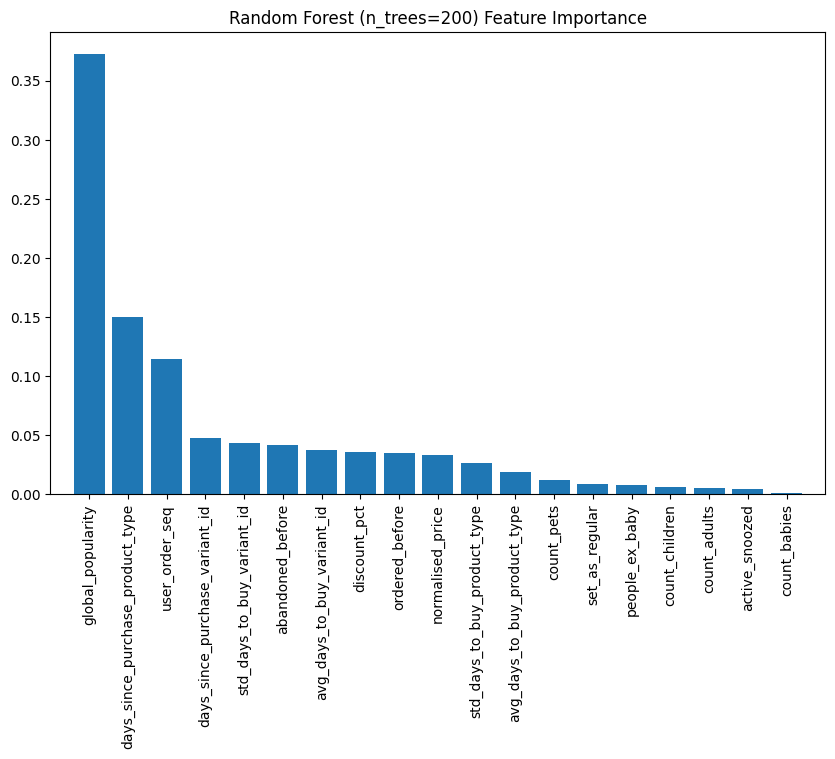

In [22]:
# Train a RandomForestClassifier with 200 estimators
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

# Assuming you have already defined the feature_names variable
# If not, you can define it like this:
# feature_names = X_train.columns

# Plot feature importance for the trained RandomForest model
plot_feature_importance(rf, feature_names, title="Random Forest (n_trees=200) Feature Importance")

# Display the feature importance plot
plt.show()



If performance could be a significant issue in this case, we can consider discarding from 'count_pets' to the right at a later time. However, we would continue in this case with all the cols

## Gradient Boosting Trees

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

# Let's be conservative for reducing total time
n_trees_values = [5, 100, 250]
max_depth_values = [1, 3, 5]

trained_gbt_models = []
y_preds_gbt = []
gbt_model_names = []

for n_trees in n_trees_values:
    for depth in max_depth_values:
        gbt = GradientBoostingClassifier(
            n_estimators=n_trees,
            max_depth=depth
            )
        gbt.fit(X_train, y_train)

        trained_gbt_models.append(gbt)
        y_preds_gbt.append(gbt.predict_proba(X_val)[:, 1])
        gbt_model_names.append(f"GBT (n_trees={n_trees}, depth={depth})")

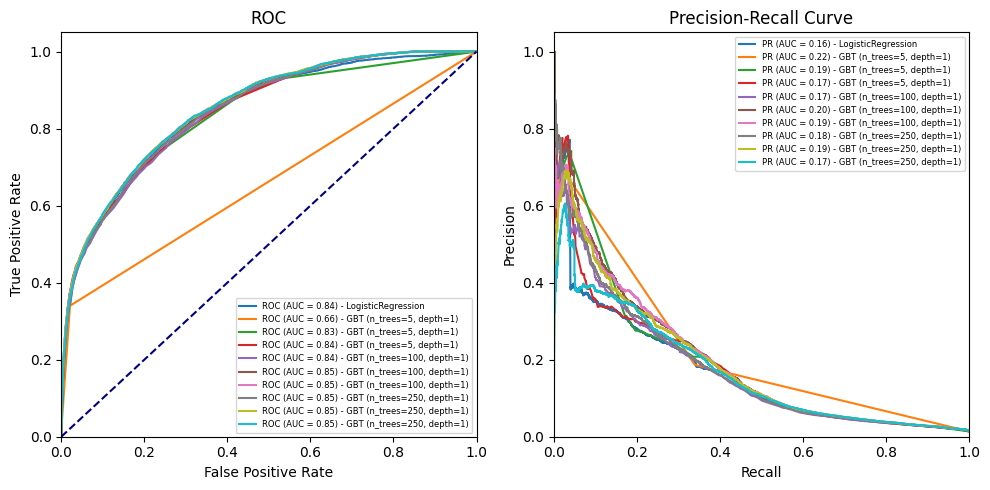

In [59]:
lr_model_name = ["LogisticRegression"]
rf_model_names = [f"RandomForest (n_trees={n})" for n in n_trees_values]

all_model_names = lr_model_name  + gbt_model_names
all_y_preds = [y_pred_lr]  + y_preds_gbt

# Now use the generate_evaluation_curves_multi function to plot:
generate_evaluation_curves_multi(
    model_names=all_model_names,
    y_preds=all_y_preds,
    y_test=y_val
)

GBT with n_trees = 100 and depth = 3 seems to be our best model (brown line, legend is wrong for depth values) yet very similar to LR. As additional info, all models took around 30 min to run (again, if we need that info into account).

## XGBoost

In [23]:
X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed, cols=cols)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


In [24]:
import xgboost as xgb

# Logistic regression
lr = LogisticRegression(penalty="l2", C=1e-5, solver="liblinear")
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_val)[:, 1]

# GBT selected
gbt_model = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gbt_model.fit(X_train, y_train)
y_pred_gbt = gbt_model.predict_proba(X_val)[:, 1]

# XGBoost with different params
n_trees_values = [50, 100, 250]
max_depth_values = [3, 5]

trained_xgb_models = []
y_preds_xgb = []
xgb_model_names = []

for n_trees in n_trees_values:
    for depth in max_depth_values:
        xgb_model = xgb.XGBClassifier(
            objective="binary:logistic",
            n_estimators=n_trees,
            max_depth=depth,
            use_label_encoder=False,
            eval_metric="logloss"
        )
        xgb_model.fit(X_train, y_train)

        trained_xgb_models.append(xgb_model)
        y_preds_xgb.append(xgb_model.predict_proba(X_val)[:, 1])
        xgb_model_names.append(f"XGB (n_trees={n_trees}, depth={depth})")           
      

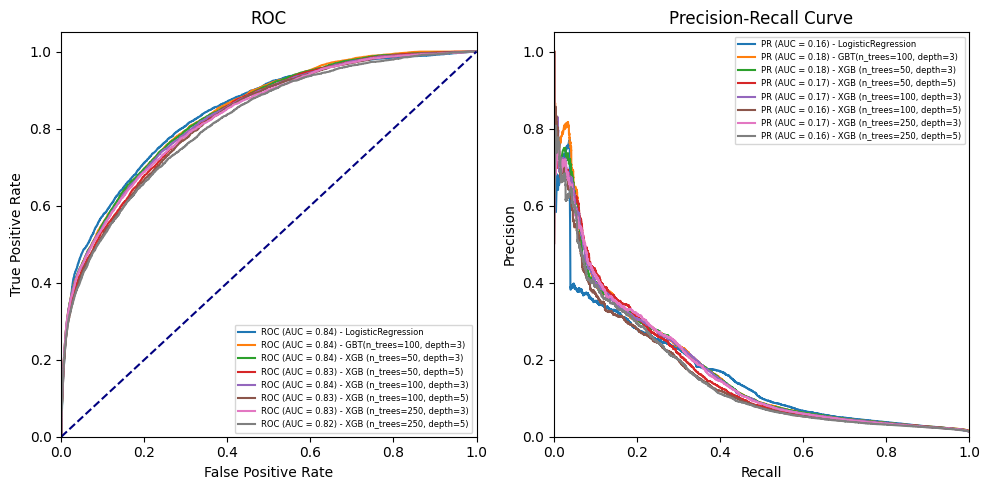

In [28]:
# Evaluate
generate_evaluation_curves_multi(
    model_names=["LogisticRegression"] + ["GBT(n_trees=100, depth=3)"] + xgb_model_names,
    y_preds=[y_pred_lr, y_pred_gbt] + y_preds_xgb,
    y_test=y_val
)

No improvement vs GBT model. Let's think a moment about the params we are using here and how we can manipulate them in order to improve the performance.
- eval_metric: It is set to logloss, however we are more intereseted in Precision-Recall curve, so we would set it to "aucpr".
- learning_rate: Let's try a different learning rate than the default (set to 0.1). Let's incorporate 0.05.
- max_depth: Let's add 6
- regularisation: Let's apply a randomsearch for lambda regularisation (l2)

In [29]:
from sklearn.model_selection import RandomizedSearchCV

# XGBoost parameters to search
params = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [0.05, 0.1],  # Added 0.05 as per your request
    'max_depth': [3, 5, 6],  # Added 6 as per your request
    'lambda': [0.1, 0.5, 1, 2, 5],  # Values for L2 regularization
    'objective': ['binary:logistic'],
    'use_label_encoder': [False],
    'eval_metric': ['aucpr']  # Changed to AUCPR as per your request
}

xgb_classifier = xgb.XGBClassifier()

# Setting up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier,
    param_distributions=params,
    n_iter=50,  # Number of parameter combinations to try
    scoring='average_precision',  # Use average precision as scoring metric
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Display progress
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all CPU cores
)

# Fitting the model
random_search.fit(X_train, y_train)

# Best model
best_xgb_model = random_search.best_estimator_

# Predictions
y_preds_best_xgb = best_xgb_model.predict_proba(X_val)[:, 1]

print(f"Best Parameters: {random_search.best_params_}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END eval_metric=aucpr, lambda=2, learning_rate=0.05, max_depth=3, n_estimators=100, objective=binary:logistic, use_label_encoder=False; total time=  30.4s
[CV] END eval_metric=aucpr, lambda=2, learning_rate=0.05, max_depth=3, n_estimators=100, objective=binary:logistic, use_label_encoder=False; total time=  30.9s
[CV] END eval_metric=aucpr, lambda=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, objective=binary:logistic, use_label_encoder=False; total time=  37.3s
[CV] END eval_metric=aucpr, lambda=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, objective=binary:logistic, use_label_encoder=False; total time=  38.0s
[CV] END eval_metric=aucpr, lambda=1, learning_rate=0.05, max_depth=5, n_estimators=100, objective=binary:logistic, use_label_encoder=False; total time=  38.6s
[CV] END eval_metric=aucpr, lambda=1, learning_rate=0.05, max_depth=5, n_estimators=100, objective=binary:logistic, use_label_encoder=

In [ ]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Assuming X_train, y_train, X_val are already defined and ready to use

# Logistic regression
lr = LogisticRegression(penalty="l2", C=1e-5, solver="liblinear")
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_val)[:, 1]

# GBT selected
gbt_model = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gbt_model.fit(X_train, y_train)
y_pred_gbt = gbt_model.predict_proba(X_val)[:, 1]

# Best XGBoost model based on the RandomizedSearchCV results
best_xgb_model = xgb.XGBClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=3,
    reg_lambda=0.5,  # 'lambda' is renamed to 'reg_lambda' in XGBClassifier
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='aucpr'
)

best_xgb_model.fit(X_train, y_train)
y_pred_best_xgb = best_xgb_model.predict_proba(X_val)[:, 1]


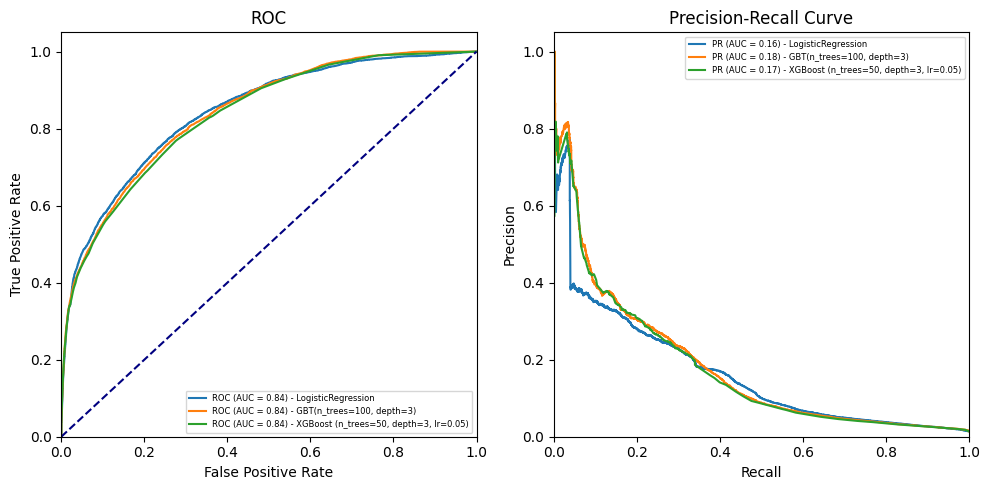

In [32]:
# Evaluate
generate_evaluation_curves_multi(
    model_names=["LogisticRegression"] + ["GBT(n_trees=100, depth=3)"] + ["XGBoost (n_trees=50, depth=3, lr=0.05)"],
    y_preds=[y_pred_lr, y_pred_gbt,y_pred_best_xgb],
    y_test=y_val
)

No luck improving the model even with best params selected from random search

## Catboost

Let's create the variable cols_with_categ to incorporate also the categorical cols into the splitting:

In [50]:
cols_with_categ = cols + categorical

In [45]:
from catboost import Pool
from catboost import CatBoostClassifier

X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed, cols = cols_with_categ)

categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical]

# Create Pool objects for train, validation, and test sets.
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
val_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


In [54]:
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',  # Use 'CrossEntropy' for multi-class problems if needed.
    eval_metric='AUC',  # This is for binary classification; use 'Accuracy' for multi-class.
    random_seed=42,
    verbose=
      # This will print out the progress every 200 iterations.
)

# Train the CatBoostClassifier
catboost_model.fit(train_pool, eval_set=val_pool)

# Predict
y_pred_catboost = catboost_model.predict_proba(val_pool)[:, 1] 

0:	test: 0.7046740	best: 0.7046740 (0)	total: 745ms	remaining: 12m 24s
200:	test: 0.8535140	best: 0.8535737 (193)	total: 2m 38s	remaining: 10m 30s
400:	test: 0.8536348	best: 0.8537726 (355)	total: 4m 49s	remaining: 7m 11s
600:	test: 0.8533836	best: 0.8537726 (355)	total: 6m 59s	remaining: 4m 38s
800:	test: 0.8527966	best: 0.8537726 (355)	total: 9m 18s	remaining: 2m 18s
999:	test: 0.8521628	best: 0.8537726 (355)	total: 12m 5s	remaining: 0us

bestTest = 0.8537725985
bestIteration = 355

Shrink model to first 356 iterations.


Model found the best iteration at 355, but converged very quickly around 200 so better to limit up to that number in the future. Being more sophisticated and continuing the performance and runtime discussion, if total time might be a crucial issue when we decided to apply catboost, we could plot the AUC vs n_iterations and visually decide at which point makes sense to limit the model.

In [52]:
# Initialize CatBoostClassifier with the best iteration
catboost_model = CatBoostClassifier(
    iterations=200,  # Set this to the optimal iteration you've found
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',  # or 'CrossEntropy' for multi-class problems
    eval_metric='AUC',  # Change this to 'Accuracy' or other metrics for multi-class
    random_seed=42,
    verbose=50  # or any number of iterations for logging the training progress
)

catboost_model.fit(train_pool, eval_set=val_pool)
y_pred_catboost = catboost_model.predict_proba(val_pool)[:, 1] 

0:	test: 0.7046740	best: 0.7046740 (0)	total: 807ms	remaining: 2m 40s
50:	test: 0.8488866	best: 0.8488977 (48)	total: 45.1s	remaining: 2m 11s
100:	test: 0.8528217	best: 0.8528217 (100)	total: 1m 28s	remaining: 1m 26s
150:	test: 0.8533697	best: 0.8533923 (148)	total: 2m 4s	remaining: 40.3s
199:	test: 0.8535048	best: 0.8535737 (193)	total: 2m 37s	remaining: 0us

bestTest = 0.8535737127
bestIteration = 193

Shrink model to first 194 iterations.


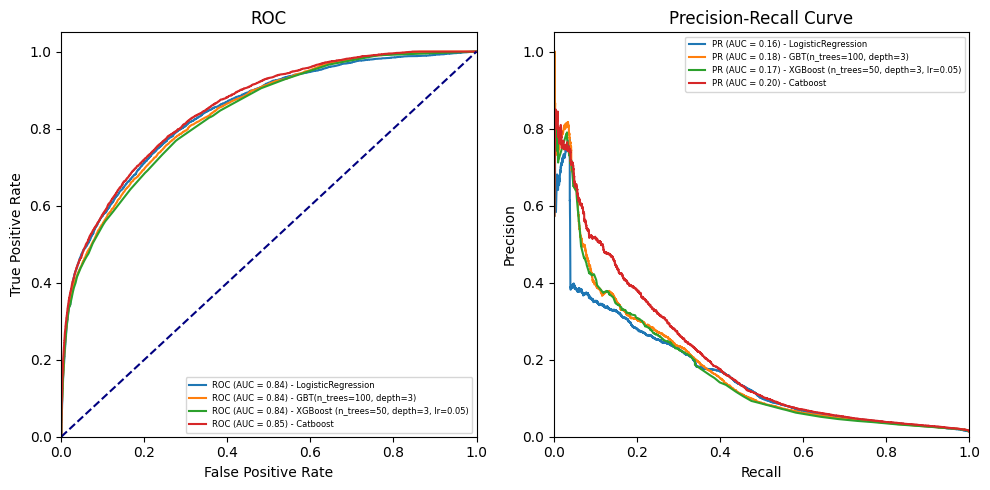

In [57]:
generate_evaluation_curves_multi(
    model_names=["LogisticRegression"] + ["GBT(n_trees=100, depth=3)"] + ["XGBoost (n_trees=50, depth=3, lr=0.05)"] + ["Catboost"],
    y_preds=[y_pred_lr, y_pred_gbt, y_pred_best_xgb, y_pred_catboost],
    y_test=y_val
)

In [39]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, probas_list, model_names):
    """Plot calibration curves for models."""
    plt.figure(figsize=(8, 6))
    
    # Plot perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
    
    for y_prob, name in zip(probas_list, model_names):
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)
        
        plt.plot(mean_predicted_value, fraction_of_positives, label=name)

    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curves")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

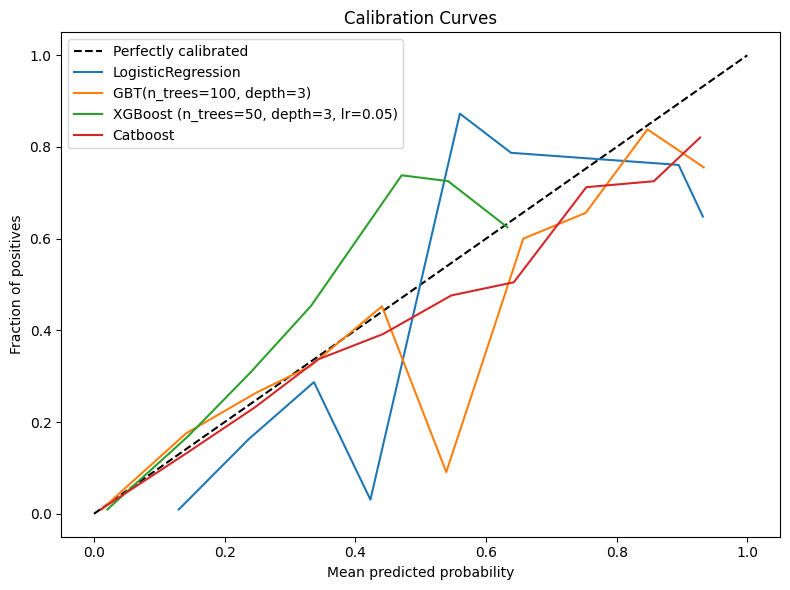

In [67]:
plot_calibration_curve(
    y_val,
    [y_pred_lr, y_pred_gbt, y_pred_best_xgb, y_pred_catboost],
    ["LogisticRegression", "GBT(n_trees=100, depth=3)", "XGBoost (n_trees=50, depth=3, lr=0.05)", "Catboost"]
)

- LR: Quite far from the diagonal, over-predicting probabilities specially in the mid-high ranges while under-predicting in mid-lows
- GBT: Well till mid probs, then under-predicting heavily in mid-highs
- XGB: Slighlty over-predicting (curiously model stops at p=0.6, which might mean it is being conversative and decides to not assign higher probs, e.g.: regularization applied or maybe model needs to be more complex for assigning higher probs)
- Catboost: Well calibrated with slightly under-predictions for mid-high ranges

I had a doubt about why predicted probability stops at 0.6 for XGBoost, so wanted to do a quick checks on that. Let's plot only the XGBoost modifications, to see if the model gains a bit of probability when it becomes more complex:

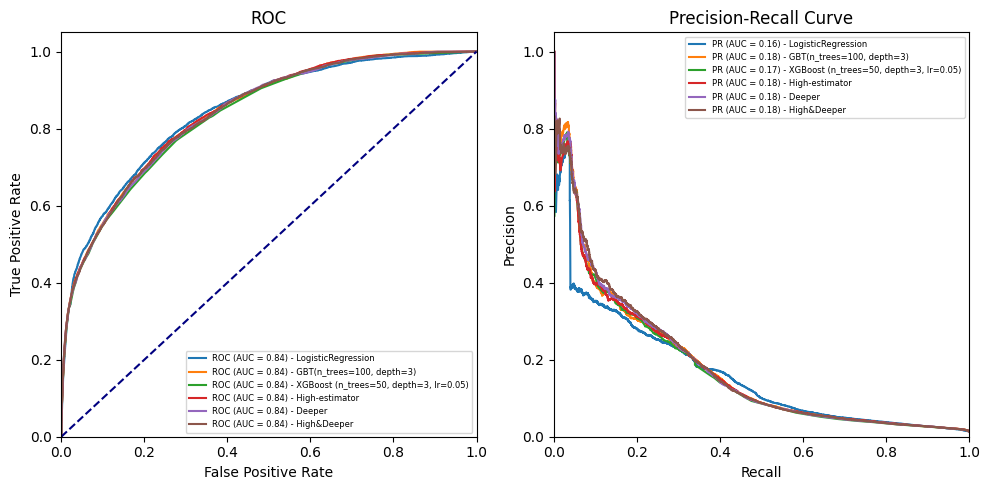

In [87]:
# Best XGBoost model based on the RandomizedSearchCV results
high_estimator_xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=3,
    reg_lambda=0.5,  # 'lambda' is renamed to 'reg_lambda' in XGBClassifier
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='aucpr'
)

high_estimator_xgb_model.fit(X_train, y_train)
y_pred_high_estimator_xgb_model = high_estimator_xgb_model.predict_proba(X_val)[:, 1]

# Best XGBoost model based on the RandomizedSearchCV results
deeper__xgb_model = xgb.XGBClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=6,
    reg_lambda=0.5,  # 'lambda' is renamed to 'reg_lambda' in XGBClassifier
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='aucpr'
)

deeper__xgb_model.fit(X_train, y_train)
y_pred_deeper__xgb_model = deeper__xgb_model.predict_proba(X_val)[:, 1]

# Best XGBoost model based on the RandomizedSearchCV results
high_deeper__xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=6,
    reg_lambda=0.5,  # 'lambda' is renamed to 'reg_lambda' in XGBClassifier
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='aucpr'
)

high_deeper__xgb_model.fit(X_train, y_train)
y_pred_high_deeper__xgb_model = high_deeper__xgb_model.predict_proba(X_val)[:, 1]

# Evaluate
generate_evaluation_curves_multi(
    model_names=["LogisticRegression"] + ["GBT(n_trees=100, depth=3)"] + ["XGBoost (n_trees=50, depth=3, lr=0.05)"] + ["High-estimator"] + ["Deeper"]+ ["High&Deeper"],
    y_preds=[y_pred_lr, y_pred_gbt,y_pred_best_xgb, y_pred_high_estimator_xgb_model, y_pred_deeper__xgb_model, y_pred_high_deeper__xgb_model ],
    y_test=y_val
)

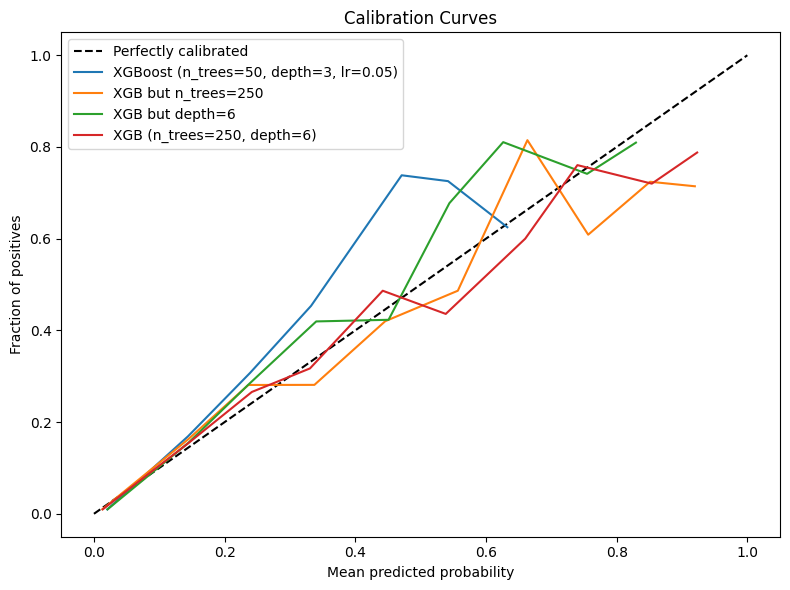

In [88]:
plot_calibration_curve(
    y_val,
    [y_pred_best_xgb, y_pred_high_estimator_xgb_model, y_pred_deeper__xgb_model, y_pred_high_deeper__xgb_model],
    ["XGBoost (n_trees=50, depth=3, lr=0.05)", "XGB but n_trees=250", "XGB but depth=6", "XGB (n_trees=250, depth=6)"]
)



Indeed they do, my gut-feeling it is that we are providing more complexity to the model, hence letting it decide with more robustness for positive outcomes (altough they are not our best model as we saw previously).

Having said that, let's move on calibrating our chosen model (catboost). Since we made use of pools, we need to extract the data from there in order to pass them into scikit libraries.

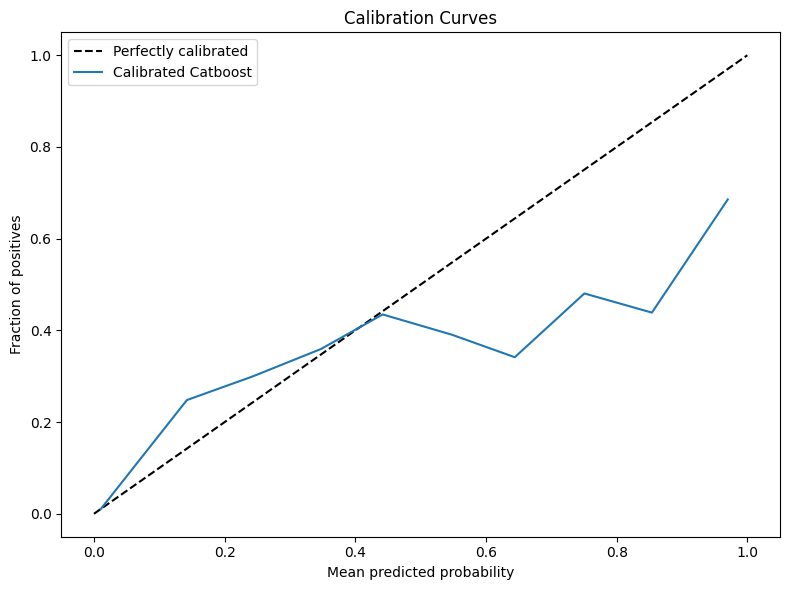

In [40]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import OneHotEncoder

def calibrate_model(model, X_train, y_train, method='sigmoid'):
    # Fit the calibrator - note that we do not need a Pool object here
    calibrated = CalibratedClassifierCV(model, method=method, cv='prefit')
    calibrated.fit(X_train, y_train)
    return calibrated

# Assuming X_val is your validation feature matrix and y_val are the validation labels:
calibrated_catboost = calibrate_model(catboost_model, X_val, y_val)

# Now we will use the calibrated model to predict probabilities on the validation set
# Create a Pool object for the validation set as we are using the CatBoost model which expects Pool object for prediction
calibrated_val_pool = Pool(X_val, cat_features=categorical_features_indices)
y_prob_calibrated_catboost = calibrated_catboost.predict_proba(calibrated_val_pool)[:, 1]

# Plot the calibration curves
plot_calibration_curve(y_val, [y_prob_calibrated_catboost], ["Calibrated Catboost"])

Nah nothing remarkable, it didn't manage the calibration very well, even it decalibrated the model xD. I guess we could try different ways of calibration (I've read a bit about monotonic and non-monotonic relationships and possible root causes about why this way might not be working well here. Rabbit hole detected so I've decided not to spend more time here at this moment :D). Will continue with catboost without calibration - as it is not that bad calibrated.

## Working point

We have decided that we will use catboost and we have some constraints defined by the business case:
- Current push notifications have an open rate of around 5% in our app
- Spamming users and uninstallation have a huge cost
- Target impact is to increase our monthly sales by 2% and a boost of 25% over
the selected items

From there, I'll some thresholds for some dimensions and we could later on decide more visually/creatively the working point:

- If open rate is around 5%, and if we believe our probability values are well calibrated, we would be playing for probabilities > 0.05
- If unistallations are that costly, let's aim to have at least >25% precision (1/4 of targeted users will buy the item)
- Let's try to be relatively sensitive to potential buyers, so let's fix recall at minimun >20%

Let's plot that:

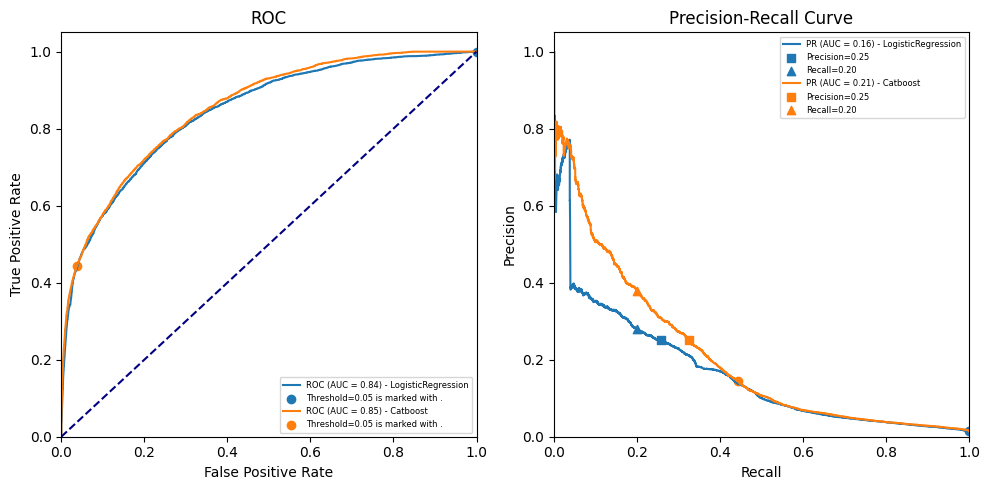

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from datetime import datetime
import os
import numpy as np

def generate_evaluation_curves_multi(
    model_names: list, y_preds: list, y_test, save_curves_path: str = None
):
    """
    Generate ROC and Precision-Recall curves for multiple binary classification models
    and display them in a single figure, with additional points for specified precision, recall, and threshold.
    """
    # Desired precision and recall values
    desired_precision = 0.25
    desired_recall = 0.20
    threshold_mark = 0.05

    # Create a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    plt.figure(figsize=(10, 5))

    # Plot for each model
    for model_name, y_pred in zip(model_names, y_preds):
        
        # ROC Curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.subplot(1, 2, 1)
        roc_line, = plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f}) - {model_name}")

        # Mark the threshold point on the ROC curve
        threshold_index = np.where(thresholds_roc >= threshold_mark)[0][-1]
        plt.scatter(fpr[threshold_index], tpr[threshold_index], color=roc_line.get_color(), marker='o', 
                    label=f'Threshold={threshold_mark} is marked with .')
        
        # Precision-Recall Curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred)
        pr_auc = auc(recall, precision)
        plt.subplot(1, 2, 2)
        pr_line, = plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.2f}) - {model_name}")

        # Mark the threshold point on the Precision-Recall curve
        threshold_index = np.where(thresholds_pr >= threshold_mark)[0][0]
        plt.scatter(recall[threshold_index], precision[threshold_index], color=pr_line.get_color(), marker='o')

        # Find and plot the additional points for desired precision and recall
        closest_precision_idx = np.argmin(np.abs(precision - desired_precision))
        closest_recall_idx = np.argmin(np.abs(recall - desired_recall))
        
        # Plot the point for the desired precision with the same color
        plt.scatter(recall[closest_precision_idx], precision[closest_precision_idx], 
                    color=pr_line.get_color(), marker='s', label=f'Precision={precision[closest_precision_idx]:.2f}')
        
        # Plot the point for the desired recall with the same color
        plt.scatter(recall[closest_recall_idx], precision[closest_recall_idx], 
                    color=pr_line.get_color(), marker='^', label=f'Recall={recall[closest_recall_idx]:.2f}')

    # ROC Curve settings
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right", prop={'size': 6})
    
    # Precision-Recall Curve settings
    plt.subplot(1, 2, 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right", prop={'size': 6})

    plt.tight_layout()

    # Save the figure if a path is provided
    if save_curves_path:
        if not os.path.exists(save_curves_path):
            os.makedirs(save_curves_path)
        figure_filename = f"Evaluation_Curves_Multiple_Models_{timestamp}.png"
        figure_path = os.path.join(save_curves_path, figure_filename)
        plt.savefig(figure_path)

    plt.show()

# Use the function with your Logistic Regression and CatBoost models
generate_evaluation_curves_multi(
    model_names=["LogisticRegression", "Catboost"],
    y_preds=[y_pred_lr, y_pred_catboost],
    y_test=y_val
)


Our working point will be somewhere between the square and triangles generated, potentially closer to the square if we want to send as much notif as possible; or closer to the triangle if we want a more conversative model for not spamming too much since we are sure we will hit our target and people from business will be more than happy with these numbers. As a last comment, we see for exactly P=.05 the performance it's almost the same, so in that specific case there will be no difference between models. There is a lot of discussion to be made here, so I'll leave it here.

# Insights

- Catboost has improved our best linear model, which was the logistic regression. We can see that the potential working area the orange dots are above the blue ones.
- We could even limit the number of iterations of our catboost model to ~50 obtaining very similar performance.
- Calibration has not been needed, already more or less calibrated
- Random Forest has not offered any advantage over logistic regression
- GBT and XGBoost were very similar to logistic regression (precision-recall a lit bit better), but runtime was considerably higher
- More extensive feature engineering could have been applied to improve the model, same for params combinations. However as a high-level approach we have covered all the principal models.

In [ ]:
data_loaded = read_data(file_path)
data_processed = preprocess_data(data_loaded)
X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed, cols = cols_with_categ)

In [41]:
def assess_NA(data: pd.DataFrame):
    """
    Returns a pd.DataFrame denoting the total number of NA
    values and the percentage of NA values in each column.
    """
    # pd.Datadenoting features and the sum of their null values
    nulls = data.isnull().sum().reset_index().rename(columns={0: "count"})
    nulls["percent"] = nulls["count"] * 100 / len(data)

    return nulls


def read_data(file_path: str) -> pd.DataFrame:
    """
    Read and validate data from a CSV file.
    Parameters: file_path (str)
    Returns: pd.DataFrame
    """
    try:
        data = pd.read_csv(file_path, index_col=False)

        if data is not None and not data.empty:
            logging.info("Data loaded successfully.")

            # Info about its shape and nulls
            rows, cols = data.shape
            logging.info(f"Data shape: {rows} rows x {cols} columns")

            null_assessment = assess_NA(data)
            logging.info(
                "Assessment of NA values:\n" + null_assessment.to_string(index=False)
            )

            # Show data sample
            print(data.head(5))

            return data
        else:
            logging.error("Error: The loaded data is empty or None")
            return

    except FileNotFoundError as e:
        logging.error(f"Error: The CSV file is empty. Details: {e}")
    except pd.errors.EmptyDataError as e:
        logging.error(
            f"Error: An unexpected error occurred while loading the data. Details {e}"
        )

def preprocess_data(
    data: pd.DataFrame, remove_if_all_na: bool = False, num_items: int = 5
) -> pd.DataFrame:
    """
    Preprocess data by removing rows with
    filter orders with at least 5 items

    Parameters:
    - data (pd.DataFrame)
    - remove_all_na_rows (bool): If True, remove rows where at least
    1 value is missing. If False, remove rows where all values are missing.

    Returns:
    - pd.DataFrame. The preprocessed dataset
    """
    try:
        initial_length = len(data)
        if remove_if_all_na:  # remove if everything is NA
            data = data.dropna(how="all")
        else:
            data = data.dropna()
        dropped_length = len(data)

        # Filter orders with >= 5 items
        num_items_ordered = data.groupby("order_id")["outcome"].transform("sum")
        processed_data = data[num_items_ordered >= num_items]

        logging.info(f"Length initial data: {len(data)}")
        logging.info(f"Rows dropped with NA's: {initial_length - dropped_length}")
        logging.info(f"Length filtered data: {len(processed_data)}\n")

        return processed_data

    except FileNotFoundError as e:
        logging.error(f"Error: File not found. Details {e}")
        return


def split_sets(df: pd.DataFrame, label: str) -> (pd.DataFrame, pd.Series):
    """
    Return a df with X set (features) and a series y set (outcome)

    Parameters:
    - df: pd.DataFrame

    Returns:
    - X: pd.DataFrame (features only)
    - y: pd.Series (label to predict)
    """
    X = df.drop(columns=label)
    y = df[label]

    return X, y


def temporal_data_split(
    data: pd.DataFrame,
    validation_days: int = 10,
    test_days: int = 10,
    label: str = "outcome",
    cols: List[str] = None,
):
    """
    Perform the temporal data splitting into train, validation, and test set.

    Parameters:
    - data : pd.DataFrame
    - validation_days (int): Number of days for the validation set (default: 10).
    - test_days (int): Number of days for the test set (default: 10).
    - label (str): Name of the outcome variable (default: 'outcome').

    Returns:
    - pd.DataFrame: Training set features.
    - pd.Series: Training set outcome.
    - pd.DataFrame: Validation set features.
    - pd.Series: Validation set outcome.
    - pd.DataFrame: Test set features.
    - pd.Series: Test set outcome.
    """
    try:
        # Check order_date is a datetime and then we group the orders
        try:
            data["order_date"] = pd.to_datetime(data["order_date"]).dt.date
        except KeyError as ke:
            logging.error(f"Key Error: {str(ke)}")
            return
        daily_orders = data.groupby("order_date").order_id.nunique()

        start_date = daily_orders.index.min()
        end_date = daily_orders.index.max()
        logging.info(f"Date from: {start_date}")
        logging.info(f"Date to: {end_date}")

        # Based on the number of days, we get the train days
        num_days = len(daily_orders)
        train_days = num_days - test_days - validation_days

        # Train
        train_start = daily_orders.index.min()
        train_end = train_start + timedelta(days=train_days)

        # Validation (no need to define test)
        validation_end = train_end + timedelta(days=validation_days)

        if cols is None:
            # Use all columns if cols is not specified
            cols = data.columns.tolist()

        train = data[data.order_date <= train_end][cols]
        val = data[(data.order_date > train_end) & (data.order_date <= validation_end)][
            cols
        ]
        test = data[data.order_date > validation_end][cols]

        logging.info(f"Train set ratio: {len(train) / len(data):.2%}")
        logging.info(f"Validation set ratio: {len(val) / len(data):.2%}")
        logging.info(f"Test set ratio: {len(test) / len(data):.2%}")

        X_train, y_train = split_sets(train, label)
        X_val, y_val = split_sets(val, label)
        X_test, y_test = split_sets(test, label)

        return X_train, y_train, X_val, y_val, X_test, y_test

    # not the best practice to catch all exceptio
    except KeyError as ke:
        logging.error(f"Key Error: {str(ke)}")
        return


def generate_evaluation_curves(
    model_name: str, y_pred, y_test, save_curves_path: str = None
):
    """
    Generate ROC and Precision-Recall curves for a binary classification model
    and save them in a single figure.

    Parameters:
    - model_name (str): Name of the model for labeling the curves.
    - y_pred (array-like): Predicted probabilities or scores.
    - y_test (array-like): True labels.
    - save_curves_path (str, optional): Directory to save the generated figure.
    If None, the figure will not be saved.

    Returns:
    - None
    """

    # Create a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y_%m_%d")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f}) - {model_name}")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(
        recall, precision, label=f"PR (AUC = {pr_auc:.2f}) - {model_name}"
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

    plt.tight_layout()

    if save_curves_path:
        # Define the filename with a timestamp
        figure_filename = f"Evaluation_Curves_{timestamp}.png"
        figure_path = os.path.join(save_curves_path, figure_filename)

        plt.savefig(figure_path)

    plt.show()

def train_catboost_model(X_train: pd.DataFrame, y_train: pd.Series,
                         X_val: pd.DataFrame, y_val: pd.Series,
                         params: Dict,
                         X_test: Optional[pd.DataFrame] = None, 
                         y_test: Optional[pd.Series] = None) -> CatBoostClassifier:
    """
    Trains a CatBoostClassifier model.

    Parameters:
    - train_data (pd.DataFrame): The training dataset features.
    - train_labels (pd.Series): The training dataset labels.
    - val_data (pd.DataFrame): The validation dataset features.
    - val_labels (pd.Series): The validation dataset labels.
    - test_data (pd.DataFrame, optional): The test dataset features.
    - test_labels (pd.Series, optional): The test dataset labels.
    - params (Dict): Dictionary containing the training parameters, which must include the names of categorical features.

    Returns:
    - CatBoostClassifier: The trained CatBoost model.
    """

    # Get the list of categorical feature names and remove it from params
    # (should not be passed to CatBoostClassifier later on)
    categorical_features = params.pop('categorical_features', None)
    categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_features]

    # Create CatBoost Pool for train and validation sets
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
    val_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)
    
    # Optionally create a Pool for the test set
    test_pool = None
    if X_test is not None and y_test is not None:
        test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

    catboost_model = CatBoostClassifier(**params)
    
    # Train the model
    catboost_model.fit(train_pool, eval_set=val_pool)

    return catboost_model

In [42]:
logging.basicConfig(
    level=logging.INFO,  # Set logging level (others: DEBUG, WARNING, ERROR, etc.)
    format="%(levelname)s - %(message)s",  # Define the log message format
)

# We will remeber the classification we did in previous notebook:

predicted = ['outcome']
information = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
numerical = ['user_order_seq', 'normalised_price', 'discount_pct', 'global_popularity',
            'count_adults', 'count_children', 'count_babies', 'count_pets', 
            'people_ex_baby', 'days_since_purchase_variant_id', 
            'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
            'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
                'std_days_to_buy_product_type']

categorical = ['product_type', 'vendor']
binary = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']

cols_with_categ = numerical + binary + categorical + predicted

In [43]:
def handler_fit(event: dict) -> dict:
    """
    The handler function to load data, train the model, and save it to disk.

    Parameters:
    - event (dict): Dictionary with input parameters such as data path, model parameters, etc.

    Returns:
    - dict: Dictionary with model information such as model name, path, etc.
    """
    try:
        # Extract parameters from event or set defaults
        data_path = event.get('data_path')
        preprocessing_params = event.get('preprocessing_params', {})
        split_params = event.get('split_params', {})
        #model_parametrisation = event["model_parametrisation"]
        model_parametrisation = event.get('model_parametrisation', {})
        save_model_path = event.get('save_model_path', 'models/')
        save_curves_path = event.get('save_curves_path', 'src/module_4/figures')


        # Load and preprocess data
        data = read_data(data_path)
        data_processed = preprocess_data(data, **preprocessing_params)

        # Split data
        X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(
            data_processed, **split_params
        )

        # Train model
        model = train_catboost_model(
            X_train, y_train,
            X_val, y_val, 
            model_parametrisation,
        )

        # Save the model
        training_date = datetime.now().strftime("%Y_%m_%d")
        model_name = f"push_{training_date}"
        model_path = os.path.join(save_model_path, model_name)
        joblib.dump(model, model_path)

        generate_evaluation_curves(model_name, model.predict_proba(X_test)[:, 1], y_test, save_curves_path)


        # Return the output dictionary
        return {
            "statusCode": "200",
            "body": json.dumps(
                {"model_path": model_path,
                 "curves_path": save_curves_path})
            }
    except Exception as e:
        traceback.print_exc()  # This will print the stack trace
        return {
            "statusCode": "500",
            "body": json.dumps({"error": str(e)})
        }

In [37]:
%cd ../..
!pwd

/home/dan1dr/zrive-ds
/home/dan1dr/zrive-ds


INFO - Data loaded successfully.
INFO - Data shape: 2880549 rows x 27 columns
INFO - Assessment of NA values:
                           index  count  percent
                      variant_id      0      0.0
                    product_type      0      0.0
                        order_id      0      0.0
                         user_id      0      0.0
                      created_at      0      0.0
                      order_date      0      0.0
                  user_order_seq      0      0.0
                         outcome      0      0.0
                  ordered_before      0      0.0
                abandoned_before      0      0.0
                  active_snoozed      0      0.0
                  set_as_regular      0      0.0
                normalised_price      0      0.0
                    discount_pct      0      0.0
                          vendor      0      0.0
               global_popularity      0      0.0
                    count_adults      0      0.0
        

       variant_id     product_type       order_id        user_id  \
0  33826472919172  ricepastapulses  2807985930372  3482464092292   
1  33826472919172  ricepastapulses  2808027644036  3466586718340   
2  33826472919172  ricepastapulses  2808099078276  3481384026244   
3  33826472919172  ricepastapulses  2808393957508  3291363377284   
4  33826472919172  ricepastapulses  2808429314180  3537167515780   

            created_at           order_date  user_order_seq  outcome  \
0  2020-10-05 16:46:19  2020-10-05 00:00:00               3      0.0   
1  2020-10-05 17:59:51  2020-10-05 00:00:00               2      0.0   
2  2020-10-05 20:08:53  2020-10-05 00:00:00               4      0.0   
3  2020-10-06 08:57:59  2020-10-06 00:00:00               2      0.0   
4  2020-10-06 10:37:05  2020-10-06 00:00:00               3      0.0   

   ordered_before  abandoned_before  ...  count_children  count_babies  \
0             0.0               0.0  ...             0.0           0.0   
1         

INFO - Length initial data: 2880549
INFO - Rows dropped with NA's: 0
INFO - Length filtered data: 2163953

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


0:	test: 0.7046740	best: 0.7046740 (0)	total: 863ms	remaining: 2m 51s
50:	test: 0.8488866	best: 0.8488977 (48)	total: 44.1s	remaining: 2m 8s
100:	test: 0.8528217	best: 0.8528217 (100)	total: 1m 23s	remaining: 1m 22s
150:	test: 0.8533697	best: 0.8533923 (148)	total: 1m 58s	remaining: 38.4s
199:	test: 0.8535048	best: 0.8535737 (193)	total: 2m 31s	remaining: 0us

bestTest = 0.8535737127
bestIteration = 193

Shrink model to first 194 iterations.


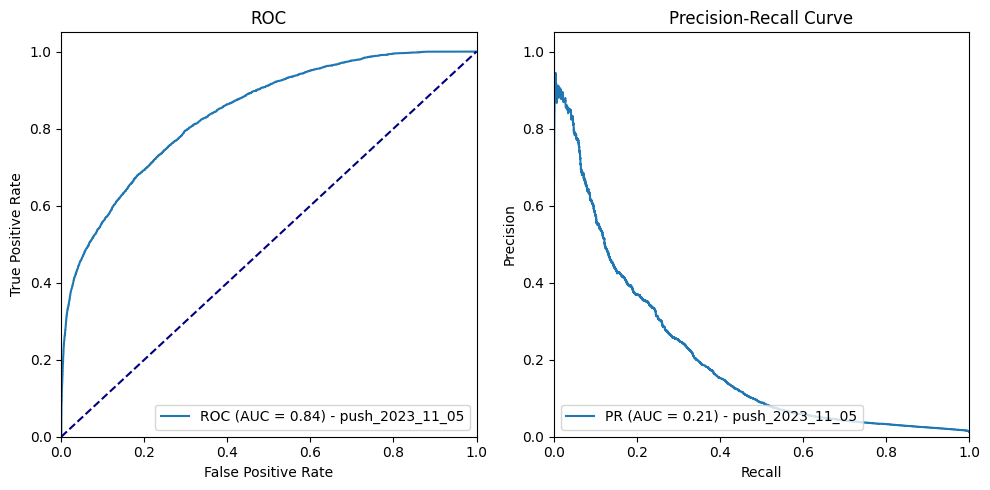

{'statusCode': '200', 'body': '{"model_path": "src/module_4/models/push_2023_11_05", "curves_path": "src/module_4/figures"}'}


In [44]:
# Define input parameters with all the necessary details
event = {
    'data_path': '/home/dan1dr/data/feature_frame.csv',
    'preprocessing_params': {
        'remove_if_all_na': True,
        'num_items': 5,
    },
    'split_params': {
        'validation_days': 10,
        'test_days': 10,
        'label': 'outcome',
        'cols': cols_with_categ,
    },
    'model_parametrisation': {
    'iterations': 200,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 50,
    'categorical_features': ['product_type', 'vendor']
    }
,
    'save_model_path': 'src/module_4/models',
    'save_curves_path': 'src/module_4/figures',
}

# Call handler_fit with the input parameters
model_info = handler_fit(event)

# Print or log the model_info
print(model_info)
